# **Preprocessing**

### **Eksplorasi Data**

Pada tahapan ini saya akan melakukan beberapa persiapan dan juga mencoba memeahami isi dari data tersebut mulai dari banyaknya data pada setiap label dan lain lain.

In [105]:
# menyiapkan library
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
import string

lalu disini saya melakukan importing pada dataset untuk mengetahui isi dari data tersebut

In [106]:
# melakukan pengambilan data
df = pd.read_csv("TABEL DATA LATIH HATESPEECH RISET.xlsx - Sheet1.csv")

# melihat data
df.head()

,username,comment,label
0,dxndelin,@amyliarm lingkunganmu keknya punya pemahaman ...,Netral
1,__succiduous,Udah jelek brengsek pula,Ras
2,KemenagMempawah,Lucunya penghuni negeri ini selalu di hiasi da...,Agama
3,1stKOREANguy1,"Yang jelek + miskin udah pasti bukan Kristen ,...",Ras
4,newsutdofficial,@MurtadhaOne1 Mereka memanfaatkan kebodohan ka...,Agama


Lalu kita akan coba telusuri banyaknya data untuk setiap labelnya. Jikalau tidak seimbang maka nantinya akan saya proses lagi. Karena kalau label tidak seimbang, maka akan berpotensi overfitting. Mengapa overfitting ? dikarenakan model akan lebih cenderung belajar pada data yang paling banyak, sehingga dia akan sulit mengenali pada data dengan class yang jumlahnya sedikit. 

In [107]:
# banyaknya data pada setiap class
df.label.value_counts()

label
Netral    836
Ras       601
Agama     563
Name: count, dtype: int64

Setelah saya lakukan analisa ternyata keseimbangan datanya sudah cukup bagus

### **Seleksi Fitur**

Pada tahapan ini kita akan mencoba menyeleksi fitur pada data kita. Kita akan menghapus untuk fitur yang tidak diperlukan. Setelah melihat datanya saya bisa menentukan bahwa fitur yang kita perlukan hanya comment dan label saja. Comment yang akan menjadi data x nya nanti dan label sebagai data y nya nanti

In [108]:
# menghilangkan fitur
df.drop(columns="username", inplace=True)

# mlihat data
df.head()

,comment,label
0,@amyliarm lingkunganmu keknya punya pemahaman ...,Netral
1,Udah jelek brengsek pula,Ras
2,Lucunya penghuni negeri ini selalu di hiasi da...,Agama
3,"Yang jelek + miskin udah pasti bukan Kristen ,...",Ras
4,@MurtadhaOne1 Mereka memanfaatkan kebodohan ka...,Agama


### **Cleaning**

**Nilai yang Hilang**

kita akan mencari apakah ada data yang hilang. Untuk memastikan bahwa data ini tidak ada yang hilang. **Mengapa harus di cek lagi ?** karena jika benar benar ada data yang hilang, maka akan berpotensi **kesalahpahaman oleh model**. Misal pada text terisi Nan (karena tidak ada nilainya) maka model akan mengira kalau text tersebut memiliki text yang berisi "Nan"

In [109]:
# jumlah nilai hilang jenis Nan
df.isna().sum()

comment    3
label      4
dtype: int64

kita dapat melihta kalau ada data kosong di kolom comment sebanyak 3 data dan data kosong di label ada 4 data. Yang kita lakukan adalah **mengdrop / menghilangkan data yang kosong** ini. Kenapa kok dihilangkan bukan di cari rata rata atau lainnya. Karena data text pada comment itu unik untuk setiap datanya. Maka tidak bisa dilakukan pencarian mean, modus, atau lain lain.

In [110]:
# melihat data unik pada label
df.label.unique()

array(['Netral', 'Ras', 'Agama', nan], dtype=object)

In [111]:
# menghilangkan data kosong
df.dropna(inplace=True)

# melihat banyak data kosong
df.isna().sum()

comment    0
label      0
dtype: int64

**Data yang Terduplikasi**

kita akan mencari apakah ada data yang terduplikasi atau tidak. **mengapa kita perlu mencari apakah ada data yang duplikasi** ? karena jika data yang terduplikasi ini dibiarkan maka akan **menimbulkan overfitting** karena model akan **cenderung menghafal** pada data yang terduplikasi. Jikalau model ini menghafal maka yang terjadi dia akan **kesulitan untuk menebak data yang baru**

In [112]:
# melihat data yang terduplikasi
df[df.comment.duplicated()]

,comment,label
143,"@VIVAcoid Sudahlah,Dia mnjabat sbg menteri saj...",Netral
144,@banjarbase Agama jgn dijadikan tolak ukur lag...,Netral
269,@yonkpaws Jelek klodia ðŸ˜”ðŸ˜”,Ras
387,gua kok ngerekam suara gue jelek amat anjir bi...,Agama
398,Ini contoh Islam yg ga bener + contoh kristen ...,Agama
...,...,...
1728,IKN Potret Kemajuan,Netral
1730,IKN Potret Kemajuan,Netral
1733,IKN Potret Kemajuan,Netral
1811,IKN Potret Kemajuan,Netral


di atas kita dapat melihat kalau **ada data yang terduplikasi**. Maka selanjutnya kita perlu menghilangkan salah satu data yang terduplikasi ini. Kita dapat menggunakan function yang ada di pandas

In [113]:
# menghilangkan data yang terduplikasi
df.drop_duplicates(inplace=True)

# melihat banyaknya data yang terduplikasi
df[df.comment.duplicated()]

,comment,label
387,gua kok ngerekam suara gue jelek amat anjir bi...,Agama
458,@RazmanZakaria60 apa sumbangan PAS kepada nega...,Agama
477,@Motty_hang yang benci FPI PKI dan kaum munafikun,Agama
491,@souIsinlove kpop k nya kafir jahat setan wall...,Agama
512,"gausah senyum kau didepan ku kntl, jelek kau b...",Ras
600,"@kompascom Maka, oleh sebab itu bertindaklah s...",Ras
1671,@apoycuy Tokoh agama di Papua kecam penyeranga...,Ras


### **Train Test Split**

Pada tahapan ini kita akan melakukan splitting data menjadi data yang digunakan khusus untuk train dan data yang digunakan khusus untuk test. Mengapa hal ini perlu dilakukan, karena agar kita dapat melihat performa model kita melalui data yang baru (data test)

In [114]:
# akan mengembalikan data yang sudah di split
def Train_Test_Split(x, y, random_seed=None, test_size=0.2):
    n = len(x) # banyak data

    # jika punya seed
    if random_seed:
        np.random.seed(random_seed)
    
    # banyak data test
    test_size = int(test_size * n)

    # menentukan index secara random
    indices = np.random.permutation(n)
    train_indices, test_indices = indices[test_size:], indices[:test_size]

    return x.iloc[train_indices], x.iloc[test_indices], y.iloc[train_indices], y.iloc[test_indices]

# menentukan x dan y nya
x = df["comment"]
y = df["label"]

# splitting pada data kita
X_train, X_test, y_train, y_test  = Train_Test_Split(x, y, random_seed=123)

# melihat isi data train
X_train

1178    Iya kalo anak mudanya gak ikut kebawa budaya m...
373     @lestrangeina @Sentjoko @geloraco @koherenz @s...
670     ini bener kok, gue punya temen deket yang bapa...
321     "Semangat bela negara juga melatih jiwa leader...
1803    Jokowi teken UU yang mengatur provinsi baru di...
                              ...                        
1171    @abdulhadiawang Tapi rasul tidak akan bersekon...
1397    Salam Maal Hijrah 1444H\r\n \r\n Marilah kita ...
1457    @manowar_office memang mabuk agama dan mwrasa ...
1440    @f1_tawan @brondutz @detikcom Sebut aja nama a...
1585    @moanamenfess Wibu, kpopers, k-drama lovers, g...
Name: comment, Length: 1557, dtype: object

### **Case Folding**

Pada tahapan ini kita akan menghilangkan karakter karakter yang **tidak memiliki makna dalam segi bahasa** yang ada pada data comment. Karakter seperti tag, hashtag, link, emoji, dan lain lain. Karena karakter jenis ini terlalu unik maka kita perlu menghilkangkannya. Karakter yang **terlalu unik umumnya tidak memiliki pola**.

In [115]:
# akan mengembalikan text yang sudah di case
def case_folding(text):
    # menghilangkan tag
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)
    # menghilangkan hashtag
    text = re.sub(r"#\w+", "", text)
    # menghilangkan link
    text = re.sub(r"https?://\S+", "", text)
    # menghilangkan newline atau enter
    text = re.sub(r"\n+", "", text)
    # menghilangkan \r
    text = re.sub(r"\r+", "", text)
    # menghilangkan nomer
    text = re.sub(r"\d+", "", text)

    # menghilangkan simbol
    text = text.translate(str.maketrans("", "", string.punctuation))

    # menghilangkan emoji
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U00010000-\U0010ffff"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r"", text)

    # memperkecil huruf
    return text.lower()

# mengimplementasikann untuk setiap doc
X_train = X_train.apply(case_folding)
X_train

1178    iya kalo anak mudanya gak ikut kebawa budaya m...
373           ya pengakuan itu memang hak dasar dari w...
670     ini bener kok gue punya temen deket yang bapak...
321     semangat bela negara juga melatih jiwa leaders...
1803    jokowi teken uu yang mengatur provinsi baru di...
                              ...                        
1171     tapi rasul tidak akan bersekongkol dgn pengua...
1397    salam maal hijrah h  marilah kita bersamasama ...
1457     memang mabuk agama dan mwrasa superior diatas...
1440       sebut aja nama agamanya boss sertanya bukti...
1585     wibu kpopers kdrama lovers gamers duhh bener ...
Name: comment, Length: 1557, dtype: object

### **Tokenize**

Pada tahapan ini kita akan melakukan **pemisahan** untuk setiap document nya menjadi **list kata**. Tujuannya adalah kata ini akan menjadi fitur nantinya dalam pembobotan kata

In [116]:
# akan mengembalikan documen yang sudah di tokenize
def tokenize(text):
    return word_tokenize(text)

# mengimplementasikan untuk setiap doc
X_train = X_train.apply(tokenize)
X_train

1178    [iya, kalo, anak, mudanya, gak, ikut, kebawa, ...
373     [ya, pengakuan, itu, memang, hak, dasar, dari,...
670     [ini, bener, kok, gue, punya, temen, deket, ya...
321     [semangat, bela, negara, juga, melatih, jiwa, ...
1803    [jokowi, teken, uu, yang, mengatur, provinsi, ...
                              ...                        
1171    [tapi, rasul, tidak, akan, bersekongkol, dgn, ...
1397    [salam, maal, hijrah, h, marilah, kita, bersam...
1457    [memang, mabuk, agama, dan, mwrasa, superior, ...
1440    [sebut, aja, nama, agamanya, boss, sertanya, b...
1585    [wibu, kpopers, kdrama, lovers, gamers, duhh, ...
Name: comment, Length: 1557, dtype: object

### **Normalize**

Pada proses ini kita akan mengubah kata yang **tidak baku menjadi kata baku / kata yang umum menjadi kata yang umum**. Seperti singkatan singkatan menjadi kata yang aslinya. Tujuannya adalah agar menjadikan sama makna yang disingkat dengan yang tidak disingkat

In [117]:
# kata yang harus dinormalize
norm_word = {
    "emg" : "memang",
    "saiz" : "size",
    "cino" : "cina",
    "jowo" : "jawa",
    "kite" : "kita",
    "lg" : "lagi",
    "aj" : "aja",
    "yg" : "yang",
    "pdhl" : "padahal",
    "napa" : "kenapa",
    "dh" : "sudah",
    "udh" : "sudah",
    "tdk" : "tidak",
    "sm" : "sama",
    "ga" : "tidak",
    "bgt" : "banget",
    "mentri" : "menteri",
    "embantu" : "membantu",
    "dlm" : "dalam",
    "bdang" : "bidang",
    "msh" : "masih",
    "ampe" : "sampai",
    "ky" : "kaya",
    "nnya" : "tanya",
    "krn" : "karena",
    "jir" : "anjing",
    "ajg" : "anjing",
    "anjir" : "anjing",
    "gak" : "tidak",
    "ak" : "aku",
    "dasr" : "dasar",
    "lgsg" : "langsung",
    "skrg" : "sekarang",
    "gw" : "gua",
    "w" : "gua",
    "engga" : "tidak",
    "dgn" : "dengan",
    "orng" : "orang",
    "org" : "orang",
    "ni" : "ini",
    "jgn" : "jangan",
    "mbahas" : "bahas",
    "krna" : "karena",
    "ma" : "sama",
    "sblm" : "sebelum",
    "tp" : "tapi",
    "sbg" : "sebagai"
}

# melakukan normalisasi
def normalize(text):
    return [norm_word[word] if word in norm_word else word for word in text]

# mengimplementasikan untuk setiap doc
X_train = X_train.apply(normalize)
X_train

1178    [iya, kalo, anak, mudanya, tidak, ikut, kebawa...
373     [ya, pengakuan, itu, memang, hak, dasar, dari,...
670     [ini, bener, kok, gue, punya, temen, deket, ya...
321     [semangat, bela, negara, juga, melatih, jiwa, ...
1803    [jokowi, teken, uu, yang, mengatur, provinsi, ...
                              ...                        
1171    [tapi, rasul, tidak, akan, bersekongkol, denga...
1397    [salam, maal, hijrah, h, marilah, kita, bersam...
1457    [memang, mabuk, agama, dan, mwrasa, superior, ...
1440    [sebut, aja, nama, agamanya, boss, sertanya, b...
1585    [wibu, kpopers, kdrama, lovers, gamers, duhh, ...
Name: comment, Length: 1557, dtype: object

### **Menghilangkan Stopwords**

Pada tahapan ini kita akan menyeleksi kata tertentu. Kita akan **menghilangkan kata yang tidak memiliki makna secara independen**. **Mengapa harus dihilangkan ?** dikarenakan nantinya yang akan **dilakukan pembobotan** kata akan memerlukan makna yang independen pada setiap fitur nya. Jika maknanya itu dependen dan terikat pada kata yang lainnya maka akan berbeda beda maknanya. Jika makna beda, maka tidak ada pola nanti datanya. Contoh konjungsi, kata penjelas, dan lain lain.

In [118]:
# kata yang harus di stop
stopw = stopwords.words("indonesian")

# mengembalikan kata yang sudah di stop
def stopword(text):
    return [word for word in text if word not in stopw]

# mengimplementasikan untuk setiap doc
X_train = X_train.apply(stopword)
X_train

1178    [iya, kalo, anak, mudanya, kebawa, budaya, man...
373              [ya, pengakuan, hak, dasar, warga, nâ€¦]
670     [bener, gue, temen, deket, emaknya, kaya, bang...
321     [semangat, bela, negara, melatih, jiwa, leader...
1803    [jokowi, teken, uu, mengatur, provinsi, papua,...
                              ...                        
1171    [rasul, bersekongkol, penguasa, merasuah, sogo...
1397    [salam, maal, hijrah, h, marilah, bersamasama,...
1457    [mabuk, agama, mwrasa, superior, diatas, agama...
1440    [aja, nama, agamanya, boss, sertanya, bukti, k...
1585    [wibu, kpopers, kdrama, lovers, gamers, duhh, ...
Name: comment, Length: 1557, dtype: object

### **Stemming**

Pada tahapan ini kita akan melakukan pengubahan kata kata menjadi kata dasarnya. Tujuannya adalah agar memperkecil variasinya sehingga model juga akan memahami bahwa kata yang belum dasar memiliki makna yang sama dengan kata dasarnya. Misal Penyanyi menjadi nyanyi, Pemahaman menjadi paham.

In [119]:
stemmer = StemmerFactory().create_stemmer()

def stemming(text):
    return [stemmer.stem(word) for word in text]

# mengimplementasikan untuk setiap doc
X_train = X_train.apply(stemming)
X_train

1178    [iya, kalo, anak, muda, bawa, budaya, manusia,...
373                       [ya, aku, hak, dasar, warga, n]
670     [bener, gue, temen, deket, emaknya, kaya, bang...
321     [semangat, bela, negara, latih, jiwa, leadersh...
1803    [jokowi, teken, uu, atur, provinsi, papua, jul...
                              ...                        
1171    [rasul, sekongkol, kuasa, merasuah, sogok, sog...
1397    [salam, maal, hijrah, h, mari, bersamasama, ha...
1457    [mabuk, agama, mwrasa, superior, atas, agama, ...
1440    [aja, nama, agama, boss, serta, bukti, kutip, ...
1585    [wibu, kpopers, kdrama, lovers, gamers, duhh, ...
Name: comment, Length: 1557, dtype: object

**Kemunculan Data** 

Pada tahapan kita akan mencari kata yang paling sering disebut di setiap class

In [120]:
# data yang ingin dilabeli
labeled_data = X_train.to_frame()

# melabeli data
labeled_data["label"] = y_train

labeled_data

,comment,label
1178,"[iya, kalo, anak, muda, bawa, budaya, manusia,...",Netral
373,"[ya, aku, hak, dasar, warga, n]",Netral
670,"[bener, gue, temen, deket, emaknya, kaya, bang...",Netral
321,"[semangat, bela, negara, latih, jiwa, leadersh...",Netral
1803,"[jokowi, teken, uu, atur, provinsi, papua, jul...",Netral
...,...,...
1171,"[rasul, sekongkol, kuasa, merasuah, sogok, sog...",Netral
1397,"[salam, maal, hijrah, h, mari, bersamasama, ha...",Netral
1457,"[mabuk, agama, mwrasa, superior, atas, agama, ...",Agama
1440,"[aja, nama, agama, boss, serta, bukti, kutip, ...",Agama


kata paling sering untuk class untuk class ras

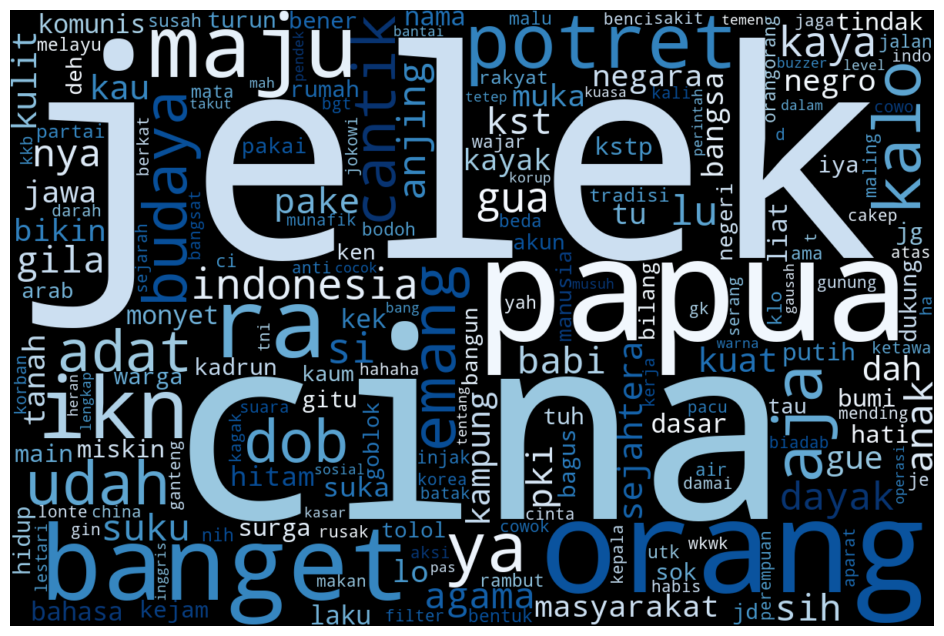

In [121]:
from wordcloud.wordcloud import WordCloud

# menampilkan data
def showing(wc):
    plt.figure(figsize=(12,8)) # ukuran
    plt.axis("off") 
    plt.imshow(wc, interpolation="bilinear")
    plt.show

# semua kata
allword = "".join([str(text).replace("'", "") for text in labeled_data.comment[labeled_data.label == "Ras"]])

# menyiapkan  komponen wordcloud
word_cloud = WordCloud(
    height=800,
    width=1200,
    collocations=False,
    colormap="Blues_r"
 ).generate(allword)

showing(word_cloud)

kata paling sering untuk class untuk class Agama

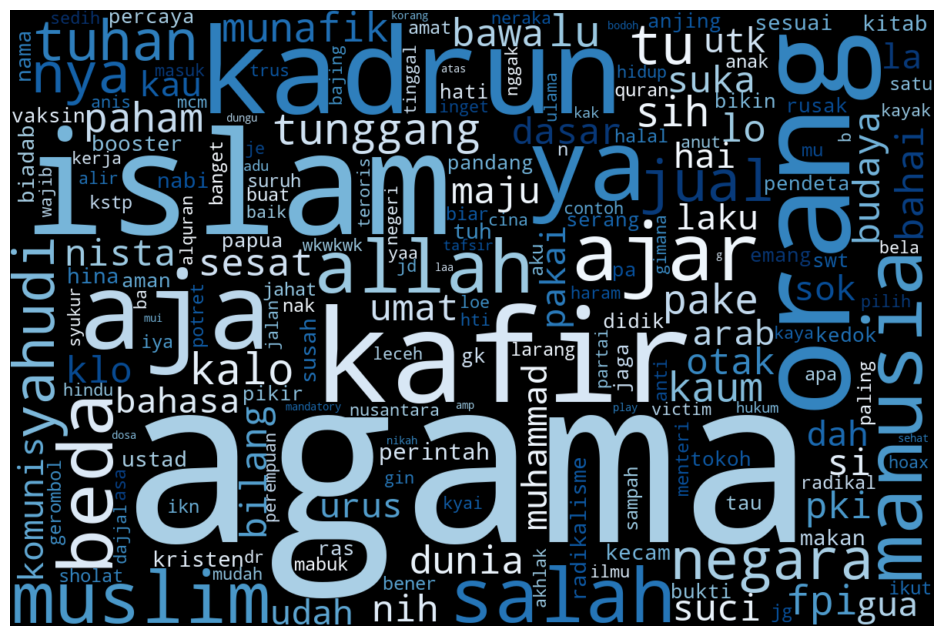

In [123]:
# menampilkan data
def showing(wc):
    plt.figure(figsize=(12,8)) # ukuran
    plt.axis("off") 
    plt.imshow(wc, interpolation="bilinear")
    plt.show

# semua kata
allword = "".join([str(text).replace("'", "") for text in labeled_data.comment[labeled_data.label == "Agama"]])

# menyiapkan  komponen wordcloud
word_cloud = WordCloud(
    height=800,
    width=1200,
    collocations=False,
    colormap="Blues_r"
 ).generate(allword)

showing(word_cloud)

kata paling sering untuk class untuk class netral

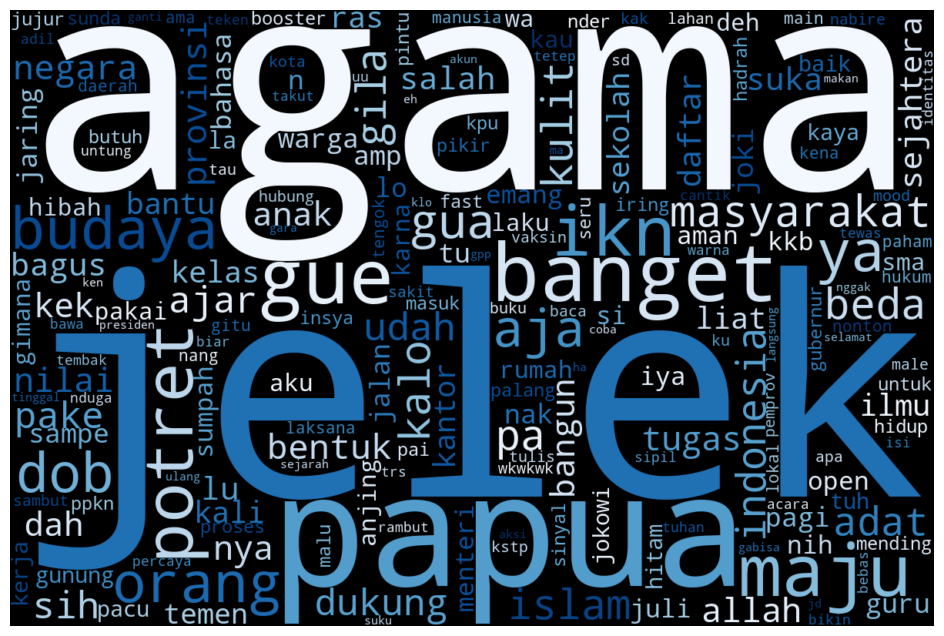

In [122]:
# menampilkan data
def showing(wc):
    plt.figure(figsize=(12,8)) # ukuran
    plt.axis("off") 
    plt.imshow(wc, interpolation="bilinear")
    plt.show

# semua kata
allword = "".join([str(text).replace("'", "") for text in labeled_data.comment[labeled_data.label == "Netral"]])

# menyiapkan  komponen wordcloud
word_cloud = WordCloud(
    height=800,
    width=1200,
    collocations=False,
    colormap="Blues_r"
 ).generate(allword)

showing(word_cloud)